# Refresher on Backpropagating through Neural Networks
This will be based on the network decsribed in https://mattmazur.com/2015/03/17/a-step-by-step-backpropagation-example/

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from pylab import *

%matplotlib inline

In [39]:
def sigmoid_func(in_vec, derivative_of=False):
    if not derivative_of:
        return 1 / (1 + np.exp(-in_vec))
    base_value = sigmoid_func(in_vec, derivative_of=False)
    return np.multiply(base_value, (1 - base_value))

In [40]:
def relu_func(in_vec, derivative_of=False):
    if not derivative_of:
        return np.maximum(in_vec, 0)
    copy_vec = np.copy(in_vec)
    copy_vec[copy_vec >= 0] = 1
    copy_vec[copy_vec < 0] = 0 
    return copy_vec

In [41]:
def mean_squared_error(true_y, pred_y, derivative_of=False):
    if not derivative_of:
        return (1 / 2) * np.sum((true_y - pred_y) ** 2)
    return np.sum(pred_y - true_y)

In [42]:
def stochastic_gradient_descent(orig_layer_w, layer_delta_w, learning_rate=0.1):
    return orig_layer_w - (learning_rate * layer_delta_w)

In [143]:
class BasicModel:
    def __init__(self, init_weights, layer_activations, add_bias=True, batch_size=None):
        self.add_bias = add_bias
        self.network_weights = np.copy(init_weights)
        self.layers_activations = np.copy(layer_activations)
        if batch_size is None:
            batch_size = 1
        self.batch_size = batch_size
        value_cache_layout = []
        for layer_weight_base in self.network_weights:
            output_shape = (batch_size, layer_weight_base.shape[0])
            zeros = [[0.] * layer_weight_base.shape[0]] * batch_size
            value_cache_layout.append([zeros, zeros])
        self.network_value_cache = np.array(value_cache_layout)
    
    def forward_pass(self, in_vec):
        if len(in_vec.shape) == 1:
            output_cache = in_vec.reshape((1, in_vec.shape[0]))
        else:
            output_cache = np.copy(in_vec)
        self.input_cache = np.copy(output_cache)

        for i, (layer_weights, activation) in enumerate(zip(self.network_weights, self.layers_activations)):
            if self.add_bias:
                bias_terms = [1] * output_cache.shape[0]
                output_cache = np.column_stack((output_cache, bias_terms))
            print(self.network_value_cache[i][0])
            print(np.matmul(output_cache, layer_weights.transpose()))
            self.network_value_cache[i][0] = np.matmul(output_cache, layer_weights.transpose())
            self.network_value_cache[i][1] = activation(self.network_value_cache[i][0])
            output_cache = self.network_value_cache[i][1]
        return self.network_value_cache[self.network_value_cache.shape[0] - 1][1]
    
    def backward_pass(self, y_true):
        sigma_cache = []
        # Backprop last layer and calculate sigma oi's
        net_out, layer_out = self.network_value_cache[self.network_value_cache.shape[0] - 1]
        div_E_out = layer_out - y_true
        div_out_net = self.layers_activations[len(self.layers_activations) - 1](net_out, derivative_of=True)
        div_E_net = np.multiply(div_E_out, div_out_net)   # This is the sigma for this layer
        sigma_cache.append(div_E_net)
        
        # Backprop through rest of layers
        num_hidden_layers = self.network_value_cache.shape[0] - 1 # Subtract 1 because we take care of last layer already
        for i in reversed(range(0, num_hidden_layers)):
            net_out, layer_out = self.network_value_cache[i]
            div_E_out = np.matmul(
                sigma_cache[num_hidden_layers - i - 2],
                self.network_weights[i + 1][:, :-1], 
            )
            div_out_net = self.layers_activations[i](net_out, derivative_of=True)
            div_E_net = np.multiply(div_E_out, div_out_net)
            sigma_cache.append(div_E_net)
        sigma_cache = np.array(sigma_cache)[::-1]
        
        # Forward through sigmas and w's to get dW's
        delta_w = []
        # Do first layer separately because using input X rather than previous layer output
        if self.add_bias:
            bias_terms = [1] * self.input_cache.shape[0]
            layer_input = np.column_stack((self.input_cache, bias_terms))
        else:
            layer_input = self.input_cache.transpose()
        div_E_w = np.matmul(sigma_cache[0].transpose(), layer_input)
        delta_w.append((1 / self.batch_size) * div_E_w)
        # Do the rest of the layers
        for i, layer_sigma in enumerate(sigma_cache[1:]):
            prev_net_out, prev_layer_out = self.network_value_cache[i]
            if self.add_bias:
                bias_terms = [1] * prev_layer_out.shape[0]
                layer_input = np.column_stack((prev_layer_out, bias_terms))
            else:
                layer_input = prev_layer_out
            div_E_w = np.matmul(layer_sigma.transpose(), layer_input)
            delta_w.append((1 / self.batch_size) * div_E_w)
        # Average over minibatch and return dW's
        return delta_w
    
    def update(self, delta_w, optimizer_func, lr):
        for i, layer_delta_w in enumerate(delta_w):
            self.network_weights[i] = optimizer_func(self.network_weights[i], layer_delta_w, lr)
    
    def fit_std(self, x, y_true, epochs=100, loss_function=None, optimizer_func=None, lr=0.1):
        loss_history = []
        for i in range(epochs):
            y_pred = self.forward_pass(x)
            loss_history.append(loss_function(y_true, y_pred))
            if (i % int(epochs/4)) == 0:
                print('Epoch ' + str(i) + ' loss: ' + str(loss_history[len(loss_history) - 1]))
            d_w = self.backward_pass(y_true)
            self.update(d_w, optimizer_func, lr=lr)
        return loss_history

In [124]:
def plot_history(model_history):
    ax1, ax2 = plt.subplot(211), plt.subplot(212)
    ax1.plot(model_hist)
    ax1.set_xscale('log')
    ax1.set_ylabel('loss')
    ax2.plot(model_hist)
    ax2.set_yscale('log')
    ax2.set_ylabel('loss')
    ax2.set_xlabel('epoch')
    plt.show()

## Small (2 layer) NN

In [125]:
# Starting weights
input_vec = np.array([.05,.1])
true_y = np.array([.01,.99])
w_h = np.array([
    [.15, .25, .35],
    [.2,  .30,  .35]
])
w_o = np.array([
    [.40, .45, .60],
    [.50, .55, .60]
])

In [144]:
model = BasicModel(init_weights=[w_h, w_o], layer_activations=[sigmoid_func, sigmoid_func])

In [127]:
model_hist = []
for lr in [0.5, 0.25, 0.1, 0.01, 0.001]:
    epoch_hist = model.fit_std(
        x=input_vec, 
        y_true=true_y, 
        epochs=30001, 
        loss_function=mean_squared_error, 
        optimizer_func=stochastic_gradient_descent,
        lr=lr
    )
    model_hist += epoch_hist

Epoch 0 loss: 0.298390054478
Epoch 7500 loss: 5.67232090434e-06
Epoch 15000 loss: 5.64907152139e-07
Epoch 22500 loss: 7.88482581799e-08
Epoch 30000 loss: 1.22081756465e-08
Epoch 0 loss: 1.2205180364e-08
Epoch 7500 loss: 4.88190421574e-09
Epoch 15000 loss: 1.96384729632e-09
Epoch 22500 loss: 7.92871574211e-10
Epoch 30000 loss: 3.20861358452e-10
Epoch 0 loss: 3.20822695923e-10
Epoch 7500 loss: 2.23519974305e-10
Epoch 15000 loss: 1.55760755965e-10
Epoch 22500 loss: 1.08561867927e-10
Epoch 30000 loss: 7.56769252929e-11
Epoch 0 loss: 7.56732850491e-11
Epoch 7500 loss: 7.29919058473e-11
Epoch 15000 loss: 7.04056304285e-11
Epoch 22500 loss: 6.79110811484e-11
Epoch 30000 loss: 6.55050005418e-11
Epoch 0 loss: 6.5504685489e-11
Epoch 7500 loss: 6.52688226634e-11
Epoch 15000 loss: 6.50338099339e-11
Epoch 22500 loss: 6.47996442287e-11
Epoch 30000 loss: 6.45663224909e-11


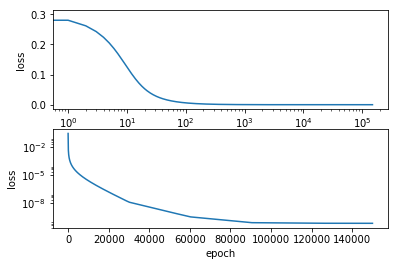

In [128]:
plot_history(model_hist)

In [129]:
y_pred = model.forward_pass(input_vec)
print('True y: ' + str(true_y))
print('Predicted y: ' + str(y_pred))

True y: [ 0.01  0.99]
Predicted y: [[ 0.01000853  0.98999249]]


## Larger (3 layer) 2->3->2->2 NN

In [145]:
# Starting weights
input_vec2 = np.array([.05,.1])
true_y2 = np.array([.01,.99])
w_h21 = np.array([
    [.40, .30, .50],
    [.70, .63, .33],
    [.23, .43, .73]
])
w_h22 = np.array([
    [.15, .25, .66, .35],
    [.2,  .30, .29, .35]
])
w_o2 = np.array([
    [.40, .45, .60],
    [.50, .55, .60]
])

In [146]:
model_big = BasicModel(
    init_weights=[w_h21, w_h22, w_o2], 
    layer_activations=[sigmoid_func, sigmoid_func, sigmoid_func]
)

In [147]:
model_hist = []
for lr in [0.5, 0.25, 0.1, 0.01, 0.001]:
    epoch_hist = model_big.fit_std(
        x=input_vec, 
        y_true=true_y, 
        epochs=100001, 
        loss_function=mean_squared_error, 
        optimizer_func=stochastic_gradient_descent,
        lr=lr
    )
    model_hist += epoch_hist

[[0.0, 0.0, 0.0]]
[[ 0.55    0.428   0.7845]]


ValueError: could not broadcast input array from shape (3) into shape (1)

In [139]:
model_big.network_value_cache[1][0]

array([[0.0, 0.0]], dtype=object)

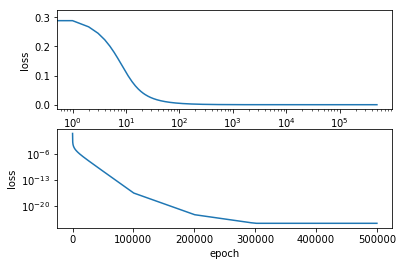

In [16]:
plot_history(model_hist)

In [17]:
y_pred = model_big.forward_pass(input_vec2)
print('True y: ' + str(true_y2))
print('Predicted y: ' + str(y_pred))

True y: [ 0.01  0.99]
Predicted y: [ 0.01  0.99]


In [18]:
model_big.network_weights

array([ array([[ 0.39828278,  0.29656556,  0.46565555],
       [ 0.69673126,  0.62346252,  0.26462525],
       [ 0.21480253,  0.39960506,  0.42605059]]),
       array([[ 0.41042405,  0.49537639,  0.92315088,  0.76628642],
       [ 0.46430831,  0.54896316,  0.5565346 ,  0.77261816]]),
       array([[-1.59381313, -1.45148161, -1.97847675],
       [ 1.55382308,  1.56165418,  1.91960895]])], dtype=object)

## ReLU Network

In [19]:
# Starting weights
input_vec3 = np.array([.05,.1])
true_y3 = np.array([.01,.99])
w_h31 = np.array([
    [.40, .30, .50],
    [.70, .63, .33],
    [.23, .43, .73]
])
w_h32 = np.array([
    [.15, .25, .66, .35],
    [.2,  .30, .29, .35]
])
w_o3 = np.array([
    [.40, .45, .60],
    [.50, .55, .60]
])

### ReLU network dies with high Learning Rate

In [20]:
model_big_relu = BasicModel(
    init_weights=[w_h31, w_h32, w_o3], 
    layer_activations=[relu_func, relu_func, relu_func]
)

model_hist = []
for lr in [0.5, 0.01, 0.001]:
    epoch_hist = model_big_relu.fit_std(
        x=input_vec3, 
        y_true=true_y3, 
        epochs=30001, 
        loss_function=mean_squared_error, 
        optimizer_func=stochastic_gradient_descent,
        lr=lr
    )
    model_hist += epoch_hist

Epoch 0 loss: 1.12479929463
Epoch 7500 loss: 5e-05
Epoch 15000 loss: 5e-05
Epoch 22500 loss: 5e-05
Epoch 30000 loss: 5e-05
Epoch 0 loss: 5e-05
Epoch 7500 loss: 5e-05
Epoch 15000 loss: 5e-05
Epoch 22500 loss: 5e-05
Epoch 30000 loss: 5e-05
Epoch 0 loss: 5e-05
Epoch 7500 loss: 5e-05
Epoch 15000 loss: 5e-05
Epoch 22500 loss: 5e-05
Epoch 30000 loss: 5e-05


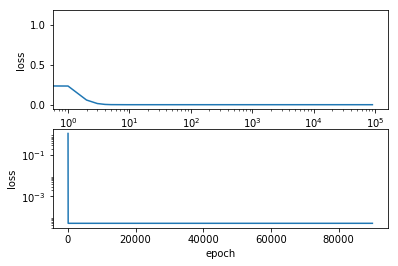

In [21]:
plot_history(model_hist)

### A more reasonable Learning Rate

In [22]:
model_big_relu = BasicModel(
    init_weights=[w_h31, w_h32, w_o3], 
    layer_activations=[relu_func, relu_func, relu_func]
)

model_hist = []
for lr in [0.01, 0.001]:
    epoch_hist = model_big_relu.fit_std(
        x=input_vec3, 
        y_true=true_y3, 
        epochs=30001, 
        loss_function=mean_squared_error, 
        optimizer_func=stochastic_gradient_descent,
        lr=lr
    )
    model_hist += epoch_hist

Epoch 0 loss: 1.12479929463
Epoch 7500 loss: 3.55348669677e-30
Epoch 15000 loss: 3.55348669677e-30
Epoch 22500 loss: 3.55348669677e-30
Epoch 30000 loss: 3.55348669677e-30
Epoch 0 loss: 3.55348669677e-30
Epoch 7500 loss: 3.55348669677e-30
Epoch 15000 loss: 3.55348669677e-30
Epoch 22500 loss: 3.55348669677e-30
Epoch 30000 loss: 3.55348669677e-30


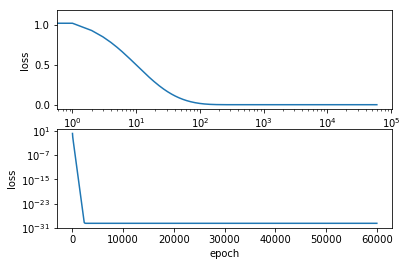

In [23]:
plot_history(model_hist)

### Learning Rate too low and it won't converge fast enough

In [24]:
model_big_relu = BasicModel(
    init_weights=[w_h31, w_h32, w_o3], 
    layer_activations=[relu_func, relu_func, relu_func]
)

model_hist = []
for lr in [0.001, 0.0001]:
    epoch_hist = model_big_relu.fit_std(
        x=input_vec3, 
        y_true=true_y3, 
        epochs=30001, 
        loss_function=mean_squared_error, 
        optimizer_func=stochastic_gradient_descent,
        lr=lr
    )
    model_hist += epoch_hist

Epoch 0 loss: 1.12479929463
Epoch 7500 loss: 1.18937654076e-10
Epoch 15000 loss: 4.75538016227e-20
Epoch 22500 loss: 4.35112165734e-28
Epoch 30000 loss: 3.73333299911e-28
Epoch 0 loss: 3.73333299911e-28
Epoch 7500 loss: 3.73333299911e-28
Epoch 15000 loss: 3.73333299911e-28
Epoch 22500 loss: 3.73333299911e-28
Epoch 30000 loss: 3.73333299911e-28


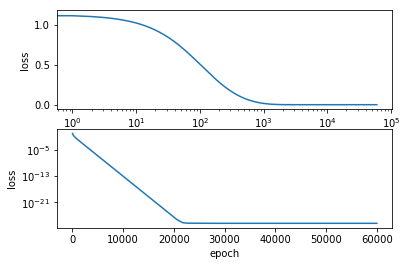

In [25]:
plot_history(model_hist)

# Mini-Batch NN
## Integrate code into BasicModel

# Convolutional Layer

# Dropout

# Batch Normalization